In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.constants import electron_volt, epsilon_0, m_p, m_n, speed_of_light, elementary_charge
# from IPython.display import clear_output
%matplotlib ipympl

In [2]:
k = 4*np.pi*epsilon_0
kinv = 1/k

m_g = 1.1578e-25 

m_g_inv = 1/m_g

q = elementary_charge

beam_energy = 0.2e-4*electron_volt

v_ave = np.sqrt(2*beam_energy/m_g)

In [32]:
lens_voltage = -0.8e5*electron_volt/elementary_charge

In [33]:
electrode1 = 2e-2
insulator1 = 2e-2
electrode2 = electrode1
insulator2 = insulator1
electrode3 = electrode1

element_dimensions = [electrode1,
                      insulator1,
                      electrode2,
                      insulator2,
                      electrode3]


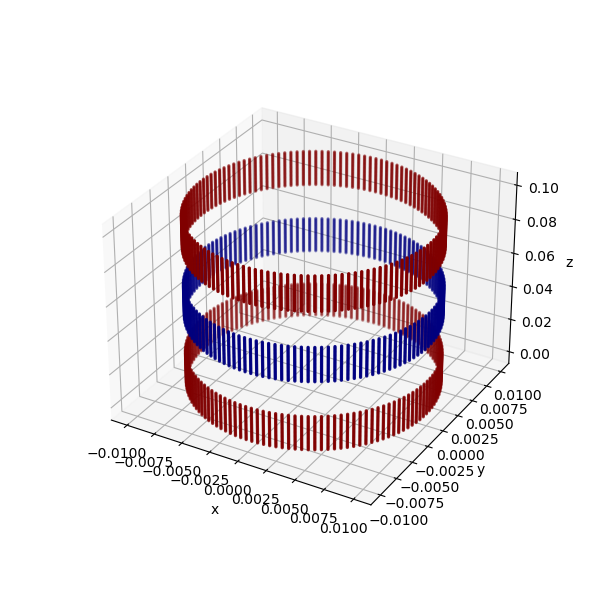

In [34]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

voltage = lens_voltage

zmin, zmax = 0, sum(element_dimensions)
zres = 128

thetamin,thetamax = 0, 2*np.pi
thetares = 128

radius = 1e-2

zgrid = np.linspace(zmin,zmax,zres)
thetagrid = np.linspace(thetamin, thetamax, thetares)[0:-1]

zdata, tdata = np.meshgrid(zgrid,thetagrid)

xdata = radius*np.cos(tdata)
ydata = radius*np.sin(tdata)

z_idx = zdata.ravel()

entry_conductor_idx = (z_idx <= electrode1)
entry_insulator_idx = (z_idx > electrode1)*(electrode1+insulator1 >= z_idx)

lens_conductor_idx = (z_idx > electrode1+insulator1)*(electrode1+insulator1+electrode2 >= z_idx)

exit_insulator_idx = (z_idx > electrode1+insulator1+electrode2)*(electrode1+insulator1+electrode2+insulator2 >= z_idx)
exit_conductor_idx = (z_idx > electrode1+insulator1+electrode2+insulator2)

potential = np.zeros_like(z_idx)

potential[entry_conductor_idx] = 0
# potential[entry_insulator_idx] = 0.5
potential[lens_conductor_idx ] = voltage
# potential[exit_insulator_idx ] = 0.5
potential[exit_conductor_idx ] = 0

insulator_idx = (~entry_insulator_idx*~exit_insulator_idx)

# potential = potential.reshape(zdata.shape)

xelem, yelem = xdata.ravel()[insulator_idx], ydata.ravel()[insulator_idx]
zelem, potentialelem = zdata.ravel()[insulator_idx], potential[insulator_idx]

ax.scatter3D(xelem, yelem, zelem, c=potentialelem, cmap='jet', s=2.0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [35]:
x_rav = xelem.ravel()
y_rav = yelem.ravel()
z_rav = zelem.ravel()

r_rav = np.sqrt(x_rav*x_rav + y_rav*y_rav + z_rav*z_rav)

xmin, xmax = xelem.min(), xelem.max()
ymin, ymax = yelem.min(), yelem.max()
zmin, zmax = zelem.min()-0*zmax, zelem.max() + 0*zmax

rmin, rmax = 1.5*radius, 2*radius
tmin, tmax = 0, 2*np.pi

xres, yres, zres, rres, tres = 10, 10, 32, 1, 64

total_res = rres*zres*tres

xl, yl, zl = np.linspace(xmin,xmax,xres), np.linspace(ymin,ymax,yres), np.linspace(zmin,zmax,zres)

rl = np.linspace(rmin, rmax, rres)
tl = np.linspace(tmin,tmax, tres)[0:-1]

# xm, ym, zm = np.meshgrid(xl, yl, zl)

rm, tm, zm = np.meshgrid(rl, tl, zl)

xm, ym = rm*np.cos(tm), rm*np.sin(tm)

xr, yr, zr = xm.ravel(), ym.ravel() ,zm.ravel() 

rr = np.sqrt(xr*xr + yr*yr + zr*zr)

In [36]:
x_matrix = xr - x_rav[:,np.newaxis]
y_matrix = yr - y_rav[:,np.newaxis]
z_matrix = zr - z_rav[:,np.newaxis]

r_matrix = np.sqrt(x_matrix*x_matrix + y_matrix*y_matrix + z_matrix*z_matrix)

inv_r_matrix = 1/r_matrix

In [37]:
inv_r_matrix.shape, inv_r_matrix.min(), inv_r_matrix.max()

((9906, 2016), 9.701425012011255, 200.00000000000003)

In [38]:
# phi(r) = int rho(r') / | r - r'| dr'
# potential = inv_r_matrix . rho
# inv_r_matrix^T potential = inv_r_matrix^T inv_r_matrix . rho
# rho = inv_r_matrix^T inv_r_matrix . inv_r_matrix^T potential

charge_density = k*np.linalg.pinv(inv_r_matrix.T@inv_r_matrix)@inv_r_matrix.T@potentialelem.ravel()

charge_density.shape

(2016,)

In [39]:
charge_density.max(), charge_density.min()

(1.0390785580680247e-07, -6.187460971102815e-08)

In [40]:
idx = (np.abs(charge_density) > 0)

np.sum(idx)

2016

In [41]:
rz_idx = rr >= 0

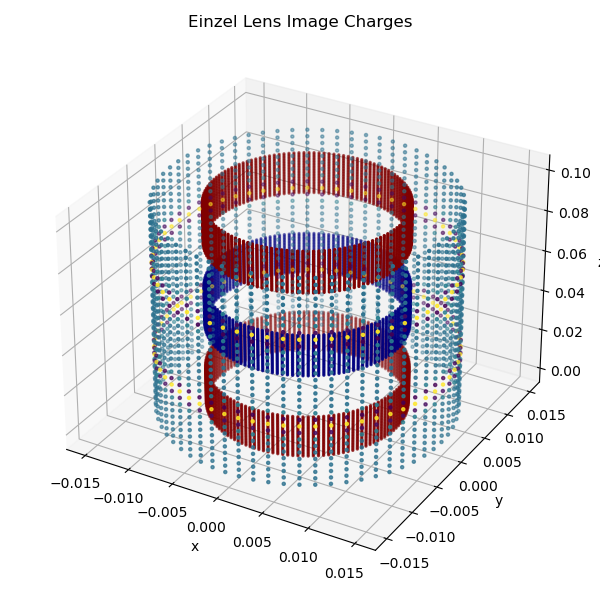

In [42]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')


ax.scatter3D(xr[idx], yr[idx], zr[idx], c=charge_density[idx], cmap='viridis', s=5.0)

ax.scatter3D(xelem, yelem, zelem, c=potentialelem, cmap='jet', s=2.0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_title("Einzel Lens Image Charges")
plt.tight_layout()
plt.show()

In [43]:
plt.close()

In [44]:
charge_density.shape, inv_r_matrix.shape

((2016,), (9906, 2016))

In [45]:
image_potential = kinv*inv_r_matrix@charge_density

In [46]:
image_potential.shape, z_rav.shape

((9906,), (9906,))

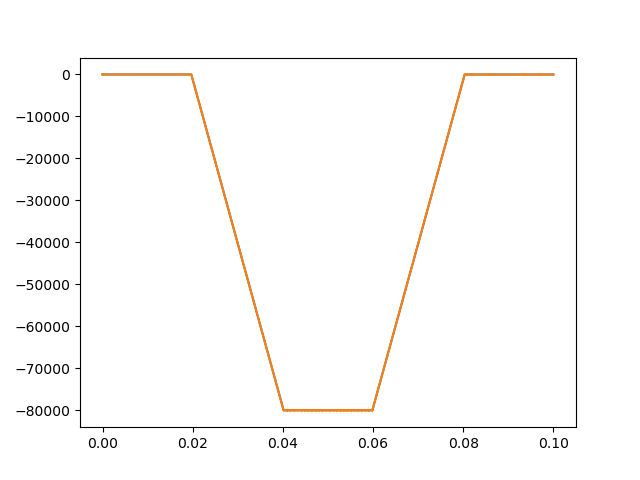

In [47]:
fig, ax = plt.subplots(1)
# ax.plot(np.sort(z_rav), image_potential[np.argsort(z_rav)])
ax.plot(np.sort(zelem), potentialelem[np.argsort(zelem)])
ax.plot(np.sort(z_rav), image_potential[np.argsort(z_rav)])
plt.show()

In [48]:
plt.close()

In [49]:
x_image = xr
y_image = yr
z_image = zr

charge_image = charge_density

x_image.shape, y_image.shape, z_image.shape, charge_image.shape

((2016,), (2016,), (2016,), (2016,))

In [50]:
def R_matrix_calc(x_particle, y_particle, z_particle, x_image, y_image, z_image):
    x_matrix = x_image - x_particle[:,np.newaxis]
    y_matrix = y_image - y_particle[:,np.newaxis]
    z_matrix = z_image - z_particle[:,np.newaxis]

    return np.sqrt(x_matrix*x_matrix + y_matrix*y_matrix + z_matrix*z_matrix)

def E_field_calc(x_particle, y_particle, z_particle, x_image, y_image, z_image, charge_image):
    
    r_matrix = R_matrix_calc(x_particle, y_particle, z_particle, x_image, y_image, z_image)
    
    r_inv_cube_matrix = np.power(r_matrix,-3)
    
    x_matrix = x_image - x_particle[:,np.newaxis]
    y_matrix = y_image - y_particle[:,np.newaxis]
    z_matrix = z_image - z_particle[:,np.newaxis]
    
    E_x = (x_matrix*r_inv_cube_matrix)@charge_image
    E_y = (y_matrix*r_inv_cube_matrix)@charge_image
    E_z = (z_matrix*r_inv_cube_matrix)@charge_image
    
    return E_x, E_y, E_z

In [51]:
particles = 50

v_sig = (v_ave/50)
v_dist = v_ave + v_sig*np.random.randn(particles)

beam_angle_ave = 0
beam_angle_sig = 0.4*(np.pi/180)

theta_dist = beam_angle_ave + beam_angle_sig*np.random.rand(particles)

phi_dist = 2*np.pi*np.random.rand(particles)

v_dist.shape, theta_dist.shape, phi_dist.shape

((50,), (50,), (50,))

In [52]:
source_z = - 10e-2
x_initial = np.zeros(particles)
y_initial = np.zeros(particles)
z_initial = np.zeros(particles) + source_z

vx_initial = v_dist*np.cos(phi_dist)*np.sin(theta_dist)
vy_initial = v_dist*np.sin(phi_dist)*np.sin(theta_dist)
vz_initial = v_dist*np.cos(theta_dist)

px_initial = m_g*vx_initial
py_initial = m_g*vy_initial
pz_initial = m_g*vz_initial

In [53]:
dt = 1e-4
time_steps = 500

t_traj = np.arange(0, time_steps*dt, dt)

x_traj =  np.zeros((time_steps, particles))
y_traj =  np.zeros((time_steps, particles))
z_traj =  np.zeros((time_steps, particles))
vx_traj = np.zeros((time_steps, particles))
vy_traj = np.zeros((time_steps, particles))
vz_traj = np.zeros((time_steps, particles))

x_traj[0]  = x_initial
y_traj[0]  = y_initial
z_traj[0]  = z_initial
vx_traj[0] = vx_initial
vy_traj[0] = vy_initial
vz_traj[0] = vz_initial

In [54]:
t_traj.shape, x_traj.shape

((500,), (500, 50))

In [55]:
for i in range(time_steps-1): #, t in enumerate(t_traj[0:-1]):
    
    x_traj[i+1] = x_traj[i] + dt*vx_traj[i]
    y_traj[i+1] = y_traj[i] + dt*vy_traj[i]
    z_traj[i+1] = z_traj[i] + dt*vz_traj[i]
    
    Ex, Ey, Ez = E_field_calc(x_traj[i], y_traj[i], z_traj[i], x_image, y_image, z_image, charge_image)
    
    vx_traj[i+1] = vx_traj[i] + dt*m_g_inv*q*Ex
    vy_traj[i+1] = vy_traj[i] + dt*m_g_inv*q*Ey
    vz_traj[i+1] = vz_traj[i] + dt*m_g_inv*q*Ez

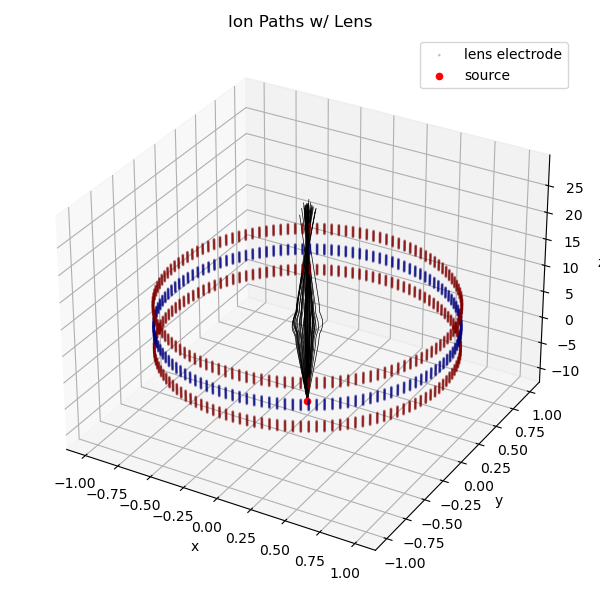

In [67]:
res = 10
scale = 1e2
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

for i in range(particles):

    ax.plot(scale*x_traj.T[i,::res], scale*y_traj.T[i,::res], scale*z_traj.T[i,::res], c='k',linewidth=0.5)

ax.scatter3D(scale*xelem, scale*yelem, scale*zelem, c=potentialelem, cmap='jet', s=1.0, alpha=0.2, label="lens electrode")

ax.scatter3D(0, 0, scale*source_z, c='r', label='source')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.legend()
plt.title("Ion Paths w/ Lens")
plt.tight_layout()
plt.show()

In [66]:
plt.close()

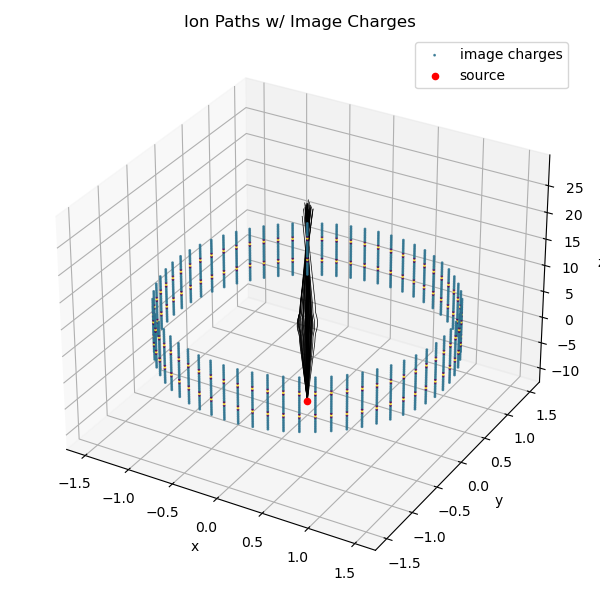

In [60]:
res = 10
scale = 1e2
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

for i in range(particles):

    ax.plot(scale*x_traj.T[i,::res], scale*y_traj.T[i,::res], scale*z_traj.T[i,::res], c='k',linewidth=0.5)

ax.scatter3D(scale*x_image, scale*y_image, scale*z_image, c=charge_image, cmap='viridis', s=1.0, alpha=0.8, label="image charges")

ax.scatter3D(0, 0, scale*source_z, c='r', label='source')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.legend()
plt.title("Ion Paths w/ Image Charges")
plt.tight_layout()
plt.show()

In [61]:
plt.close()

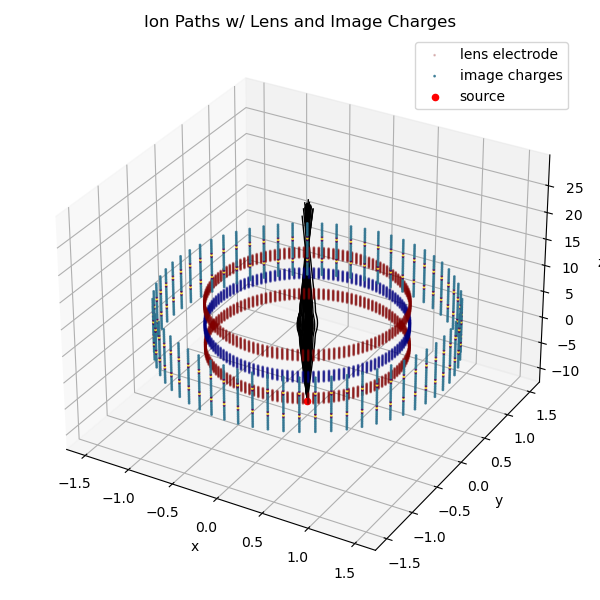

In [76]:
res = 10
scale = 1e2
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(scale*xelem, scale*yelem, scale*zelem, c=potentialelem, cmap='jet', s=1.0, alpha=0.2, label="lens electrode", zorder=-1)
ax.scatter3D(scale*x_image, scale*y_image, scale*z_image, c=charge_image, cmap='viridis', s=1.0, alpha=0.8, label="image charges",zorder=-1)

ax.scatter3D(0, 0, scale*source_z, c='r', label='source')

for i in range(particles):

    ax.plot(scale*x_traj.T[i,::res], scale*y_traj.T[i,::res], scale*z_traj.T[i,::res], c='k',linewidth=1.0, zorder=0)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.legend()
plt.title("Ion Paths w/ Lens and Image Charges")
plt.tight_layout()
plt.show()

In [77]:
plt.close()